In [4]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
from joblib import Parallel, delayed
from math import floor, ceil
import os
import pickle

# Reading Each File

* title.basics: Contains basic information like titleName, genres, runtime, startYear, etc.
* title.ratings: Contains IMDb rating information for titles.
* title.crew: Contains list of directors and writers for each title
* title.principals: Contains list of the cast for each title
* names.basics: Contains basic information about a person like name, birthYear, deathYear, along with the titles they are most known for.
* title.akas: Contains information on the various versions/languages/regions a title is released in.

## Load title.basics and title.ratings

In [5]:
## Load the data Title Basics

filtered_data_title_basic = []

for chunk in pd.read_csv("title.basics.tsv", sep="\t", chunksize=10000):
    filtered_data_title_basic.append(chunk)


title_basics = pd.concat(filtered_data_title_basic, ignore_index=True)

In [6]:
filtered_data_title_rating = []

for chunk in pd.read_csv("title.ratings.tsv", sep="\t", chunksize=10000):
    filtered_data_title_rating.append(chunk)
    
title_ratings = pd.concat(filtered_data_title_rating, ignore_index=True)

### Merge

* **tconst** (string) - alphanumeric unique identifier of the title
- 
* source_info: https://developer.imdb.com/non-commercial-datasets/

In [7]:
titles = title_basics.merge(title_ratings, on="tconst", how="left")

In [10]:
titles["endYear"] =titles["endYear"].replace("\\N", np.nan)
titles["startYear"] =titles["startYear"].replace("\\N", np.nan)
titles["startYear"]= pd.to_numeric(titles["startYear"])
titles["endYear"]= pd.to_numeric(titles["endYear"])
print(f"{titles.info()}")
print(f"Shape of the dataset: {titles.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11497554 entries, 0 to 11497553
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tconst          object 
 1   titleType       object 
 2   primaryTitle    object 
 3   originalTitle   object 
 4   isAdult         object 
 5   startYear       float64
 6   endYear         float64
 7   runtimeMinutes  object 
 8   genres          object 
 9   averageRating   float64
 10  numVotes        float64
dtypes: float64(4), object(7)
memory usage: 964.9+ MB
None
Shape of the dataset: (11497554, 11)


In [11]:
movies = titles[titles['titleType'].isin(['movie', 'tvMovie'])]
if movies["endYear"].isna().sum() == movies.shape[0]:
    movies = movies.drop("endYear", axis=1)
print(f"Information about the movies dataframe: {movies.info()}")

<class 'pandas.core.frame.DataFrame'>
Index: 858255 entries, 8 to 11497504
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          858255 non-null  object 
 1   titleType       858255 non-null  object 
 2   primaryTitle    858253 non-null  object 
 3   originalTitle   858253 non-null  object 
 4   isAdult         858255 non-null  object 
 5   startYear       750058 non-null  float64
 6   runtimeMinutes  858255 non-null  object 
 7   genres          858255 non-null  object 
 8   averageRating   381198 non-null  float64
 9   numVotes        381198 non-null  float64
dtypes: float64(3), object(7)
memory usage: 72.0+ MB
Information about the movies dataframe: None


In [12]:
# moviesto = movies.dropna(subset=["endYear"])
pd.set_option("display.max_rows", None)
movies[["primaryTitle", "titleType","startYear"]][movies["startYear"] == 2023].iloc[:20].sort_values(by="startYear", ascending=False)

,primaryTitle,titleType,startYear
69142,Socialist Realism,movie,2023.0
158725,Nine Ball,movie,2023.0
256467,Taniec trzcin,movie,2023.0
345847,Land of Nairi,movie,2023.0
421679,The Flash,movie,2023.0
737821,Moe,movie,2023.0
970015,Neil,movie,2023.0
970182,A Small Problem,movie,2023.0
974825,September,movie,2023.0
975693,The Last Voyage of the Demeter,movie,2023.0


## Filter for Movies in 2023

In [13]:
movies_2023 = movies[movies["startYear"] == 2023]
print(f"New shape of the data: {movies_2023.shape}")

New shape of the data: (22433, 10)


### Data Cleaning Process

In [14]:
movies_2023.isnull().sum()

tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear             0
runtimeMinutes        0
genres                0
averageRating     10547
numVotes          10547
dtype: int64

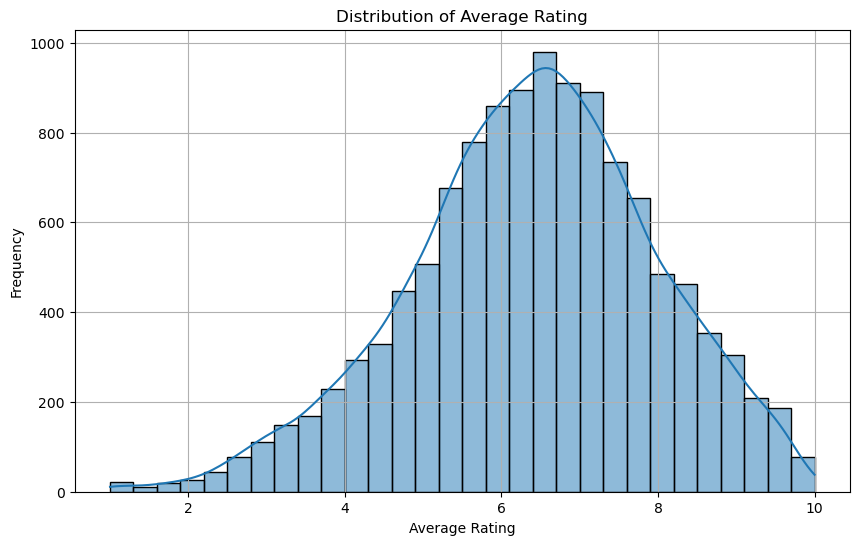

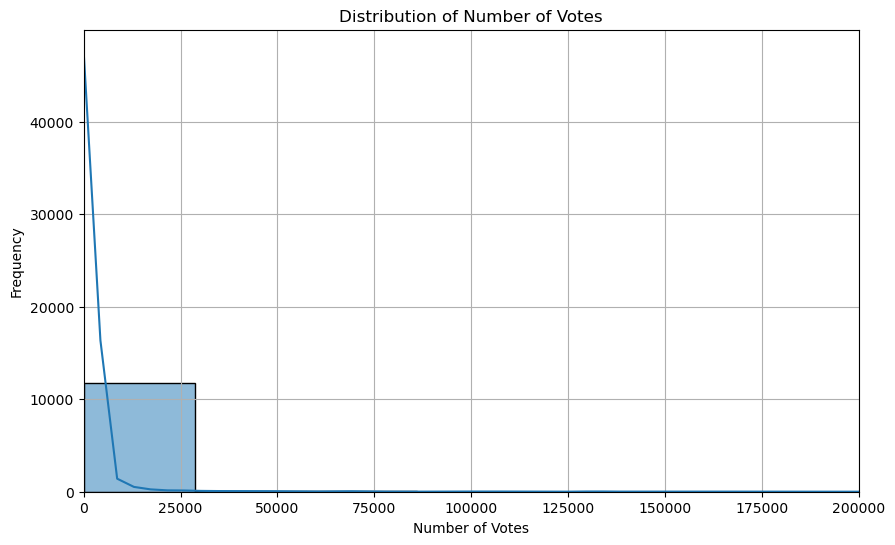

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for 'averageRating'
plt.figure(figsize=(10, 6))
sns.histplot(movies_2023['averageRating'], kde=True, bins=30)
plt.title('Distribution of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram for 'numVotes'
plt.figure(figsize=(10, 6))
sns.histplot(movies_2023['numVotes'], kde=True, bins=30)
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.xlim(0,200000)
plt.grid(True)
plt.show()


In [16]:
movies_2023["numVotes"].describe()

count     11886.000000
mean       2108.497224
std       17322.585840
min           5.000000
25%          18.000000
50%          62.000000
75%         314.750000
max      860004.000000
Name: numVotes, dtype: float64

In [18]:
# Fill missing 'averageRating' with the mean of the column
movies_2023.loc[:, 'averageRating'] = movies_2023['averageRating'].fillna(movies_2023['averageRating'].mean())

# Fill missing 'numVotes' with the median of the column
movies_2023.loc[:, 'numVotes'] = movies_2023['numVotes'].fillna(movies_2023['numVotes'].median())


In [21]:
genres = set()
titles['genres'].apply(lambda x: genres.update(x.split(',')) if isinstance(x, str) else False)
genres

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western',
 '\\N'}

### Check for Duplicates

In [22]:
movies_2023.duplicated().any()

False

### Descriptive Statistics

In [23]:
movies_2023.describe(include="all")

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
count,22433,22433,22433,22433,22433.0,22433.0,22433,22433,22433.000000,22433.000000
unique,22433,2,22073,22148,3.0,NaN,253,573,NaN,NaN
top,tt9897230,movie,Maria,Maria,0.0,NaN,\N,Documentary,NaN,NaN
freq,1,20383,4,4,22369.0,NaN,6282,5505,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,6.376216,1146.325146
std,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.145004,12650.238362
min,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,1.000000,5.000000
25%,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,6.300000,53.000000
50%,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,6.376216,62.000000
75%,NaN,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,6.600000,74.000000


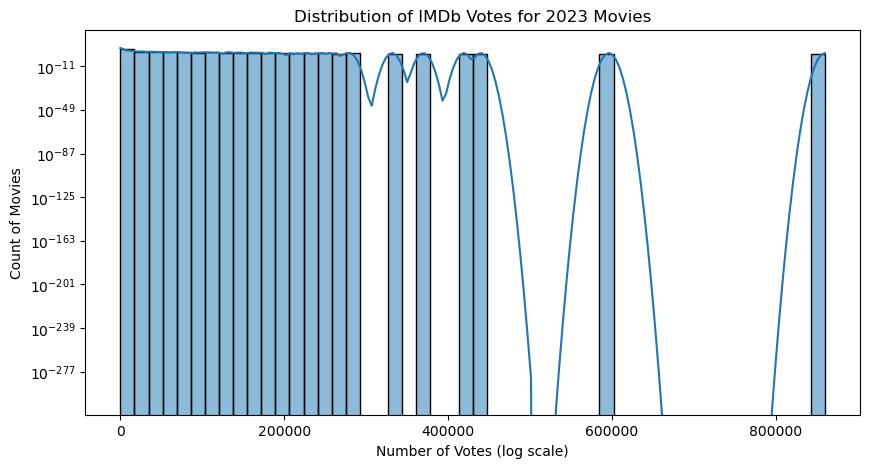

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of numVotes
plt.figure(figsize=(10,5))
sns.histplot(movies_2023["numVotes"], bins=50, kde=True)
# plt.xscale("log")  # Log scale to handle skewed data
plt.yscale("log")
plt.xlabel("Number of Votes (log scale)")
plt.ylabel("Count of Movies")
plt.title("Distribution of IMDb Votes for 2023 Movies")
plt.show()


In [24]:
percentiles = movies_2023["numVotes"].quantile([0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99])
print(f"{percentiles}")

0.25       53.00
0.50       62.00
0.75       74.00
0.80      133.00
0.85      243.00
0.90      551.00
0.95     1652.40
0.99    16915.84
Name: numVotes, dtype: float64


In [26]:
movies_2023.shape

(22433, 10)

### Best Movie in 2023 and balance with the Weighted Scoring Formula

$$
\mathbb{P}(R|v) = \frac{v}{v + m} R + \frac{m}{v + m} C
$$

where:

$$
\begin{aligned}
R &= \text{average rating of the movie} \\
v &= \text{number of votes for the movie} \\
m &= \text{minimum votes required for consideration} \\
C &= \text{mean rating across all qualifying movies}
\end{aligned}
$$


references
* Ranking Products Based on Bayesian Estimation of Ratings (J. M. Bernardo, 2003)
* Recommender Systems Handbook (Ricci, Rokach, & Shapira, 2015)

In [192]:
#Compute the Mean Rating Across All Movies
C = movies_2023["averageRating"].mean()

#Set the Minimum Votes Threshold for the 0.80 to 0.92 quantile range
# m = movies_2023["numVotes"].quantile(0.86)  # 80th percentile
# m_upper = movies_2023["numVotes"].quantile(0.95)  
m = 50000

#Filter Movies with Votes Between 80th and 92nd Percentiles
qualified_movies = movies_2023[movies_2023["numVotes"] >= m].copy()

# Step 4: Apply Weighted Rating (WR) Formula
def weighted_rating(df, m=m, C=C):
    v = df["numVotes"]
    R = df["averageRating"]
    return (v / (v + m) * R) + (m / (v + m) * C)

#Apply Weighted Rating (WR) Formula
qualified_movies.loc[:, "WR"] = qualified_movies.apply(weighted_rating, axis=1)

#Get the Top Movie Based on WR
highest_rated_movie2023 = qualified_movies.sort_values(by="WR", ascending=False).iloc[0]

print(f"Highest Rated Movie in 2023: {highest_rated_movie2023['primaryTitle']}")
print(f"Weighted Rating: {highest_rated_movie2023['WR']}")
print(f"Average Rating: {highest_rated_movie2023['averageRating']}")
print(f"Number of Votes: {highest_rated_movie2023['numVotes']}")


Highest Rated Movie in 2023: Spider-Man: Across the Spider-Verse
Weighted Rating: 8.283163411333861
Average Rating: 8.5
Number of Votes: 439720.0


In [193]:
qualified_movies.sort_values(by="WR", ascending=False).iloc[:10]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,WR
11241112,tt9362722,movie,Spider-Man: Across the Spider-Verse,Spider-Man: Across the Spider-Verse,0,2023.0,140,"Action,Adventure,Animation",8.5,439720.0,8.283163
3904986,tt15398776,movie,Oppenheimer,Oppenheimer,0,2023.0,180,"Biography,Drama,History",8.3,860004.0,8.194298
6004445,tt23849204,movie,12th Fail,12th Fail,0,2023.0,147,"Biography,Drama",8.8,143587.0,8.173981
10067901,tt6791350,movie,Guardians of the Galaxy Vol. 3,Guardians of the Galaxy Vol. 3,0,2023.0,150,"Action,Adventure,Comedy",7.9,419376.0,7.737680
3274316,tt14230458,movie,Poor Things,Poor Things,0,2023.0,141,"Comedy,Drama,Romance",7.8,331633.0,7.613462
3610406,tt14849194,movie,The Holdovers,The Holdovers,0,2023.0,133,"Comedy,Drama",7.9,195155.0,7.589220
6617598,tt27719898,movie,Kaiva,Kaiva,0,2023.0,138,"Action,Drama,Romance",8.4,68965.0,7.549420
4325868,tt16277242,movie,Society of the Snow,La sociedad de la nieve,0,2023.0,144,"Adventure,Biography,Drama",7.8,158800.0,7.459055
1170204,tt10366206,movie,John Wick: Chapter 4,John Wick: Chapter 4,0,2023.0,169,"Action,Crime,Thriller",7.6,369699.0,7.454207
2738807,tt13238346,movie,Past Lives,Past Lives,0,2023.0,105,"Drama,Romance",7.8,147198.0,7.438996


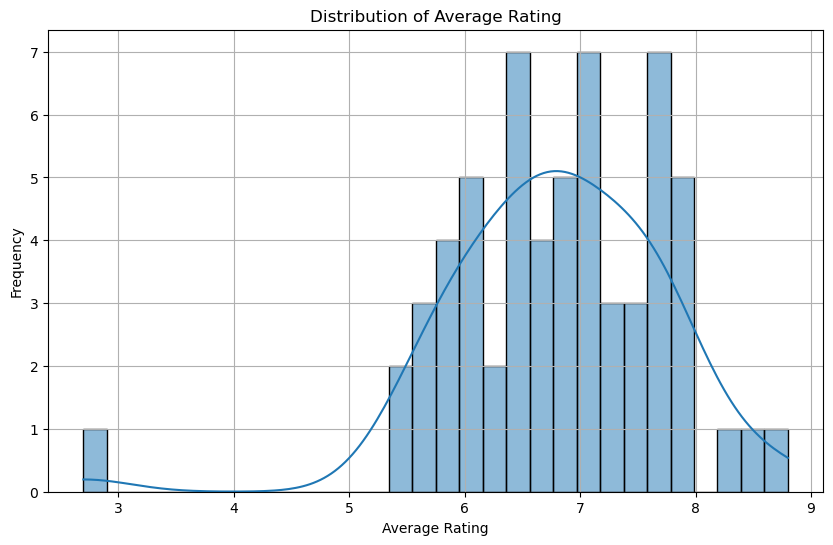

In [125]:
# Plot histogram for 'averageRating'
plt.figure(figsize=(10, 6))
sns.histplot(qualified_movies['averageRating'], kde=True, bins=30)
plt.title('Distribution of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

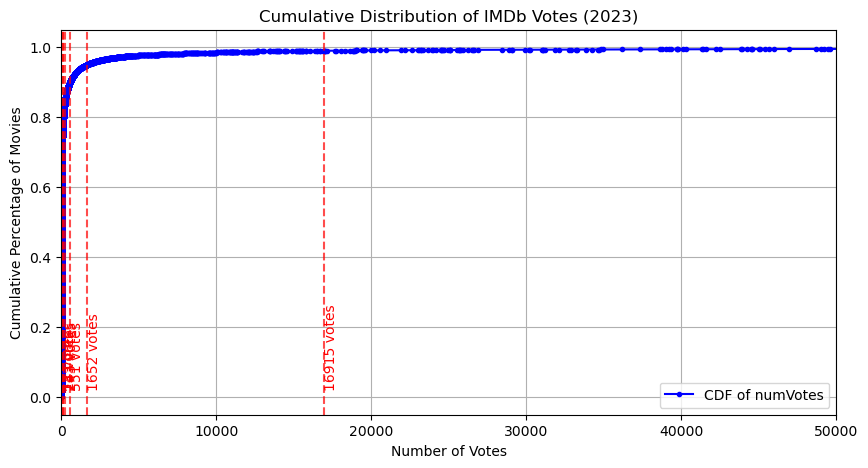

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# Sort numVotes in ascending order
numVotes_sorted = np.sort(movies_2023["numVotes"])

# Compute CDF (cumulative percentage of movies)
cdf = np.arange(1, len(numVotes_sorted) + 1) / len(numVotes_sorted)

# Compute key percentiles
percentiles = movies_2023["numVotes"].quantile([0.75, 0.80, 0.85, 0.90, 0.95, 0.99])

# Plot CDF
plt.figure(figsize=(10,5))
plt.plot(numVotes_sorted, cdf, marker=".", linestyle="-", color="blue", label="CDF of numVotes")

# Mark key percentiles
for q in percentiles:
    plt.axvline(q, linestyle="dashed", color="red", alpha=0.7)
    plt.text(q, 0.02, f"{int(q)} votes", rotation=90, verticalalignment="bottom", color="red")

# Labels & Title
plt.xlabel("Number of Votes")
plt.ylabel("Cumulative Percentage of Movies")
plt.xlim(0,50000)
plt.title("Cumulative Distribution of IMDb Votes (2023)")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


In [127]:
movie_highest_votes = movies_2023[movies_2023["numVotes"] == np.max(movies_2023["numVotes"])]
movie_highest_votes["primaryTitle"]

3904986    Oppenheimer
Name: primaryTitle, dtype: object

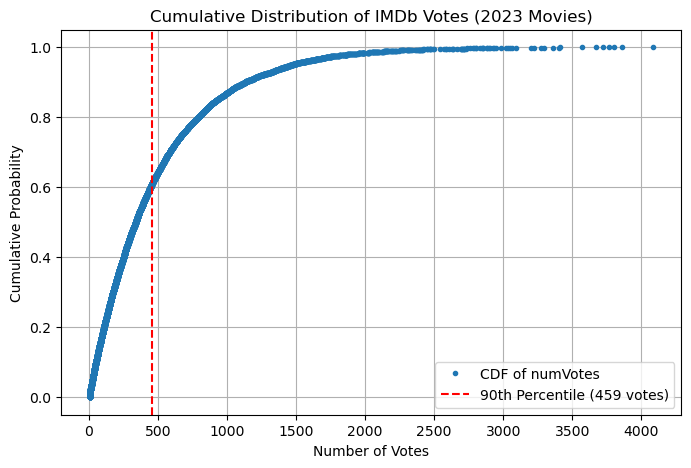

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Replace this with your actual `movies_2023_filtered["numVotes"]` data
np.random.seed(42)
num_votes = np.random.exponential(scale=500, size=10000)  # Simulating a skewed vote distribution
num_votes = np.clip(num_votes, 5, 10000)  # Clamping values to a reasonable range

# Sort votes for cumulative distribution
votes_sorted = np.sort(num_votes)

# Compute cumulative distribution
cdf = np.arange(len(votes_sorted)) / len(votes_sorted)

plt.figure(figsize=(8,5))
plt.plot(votes_sorted, cdf, marker=".", linestyle="none", label="CDF of numVotes")
plt.axvline(x=459, color="r", linestyle="--", label="90th Percentile (459 votes)")
plt.xlabel("Number of Votes")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of IMDb Votes (2023 Movies)")
plt.legend()
plt.grid()
plt.show()


## Title Crew

In [29]:
title_crew = pd.read_csv("title.crew.tsv", sep="\t", low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'title.crew.tsv'

## Name Basics

In [132]:
filtered_data_name_basic = []

for chunk in pd.read_csv("name.basics.tsv", sep="\t", chunksize=10000):
    filtered_data_name_basic.append(chunk)


name_basic = pd.concat(filtered_data_name_basic, ignore_index=True)

## Title Principals

In [133]:
filtered_data = []

# Read the file in chunks
chunk_size = 10000  # Adjust the chunk size based on your memory capacity
for chunk in pd.read_csv("title.principals.tsv", sep='\t', chunksize=chunk_size, low_memory=False):
    filtered_data.append(chunk)

# Concatenate the filtered chunks into a single DataFrame
title_principals = pd.concat(filtered_data, ignore_index=True)

In [32]:
name_basic

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
14230072,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
14230073,nm9993716,Essias Loberg,\N,\N,\N,\N
14230074,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
14230075,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [130]:
# title_principals = pd.read_csv("title.principals.tsv", sep="\t", low_memory=False)
# names_basics = pd.read_csv("names.basics.tsv", sep="\t", low_memory=False)

# Filter for 2023 movies and actors
actors_2023 = title_principals[title_principals["tconst"].isin(movies_2023["tconst"])]
actors_2023 = actors_2023[actors_2023["category"].isin(["actor", "actress"])]

# Merge with names.basics to get actor names
actors_2023 = actors_2023.merge(name_basic, on="nconst", how="left")

# Count the number of movies per actor
popular_actors = actors_2023["primaryName"].value_counts().reset_index()
popular_actors.columns = ["Actor", "Number of Movies"]

# Get the most popular actor
most_popular_actor = popular_actors.iloc[0]
print(f"Most Popular Actor in 2023: {most_popular_actor['Actor']} (Appeared in {most_popular_actor['Number of Movies']} movies)")

Most Popular Actor in 2023: Jason Young (Appeared in 89 movies)


In [134]:
# Split the 'knownForTitles' column into a list of titles
name_basic["knownForTitles"] = name_basic["knownForTitles"].str.split(",")

# Explode the list into separate rows
names_basic = name_basic.explode("knownForTitles")

# Merge with title_ratings to get ratings for known titles
names_with_ratings = names_basic.merge(title_ratings, left_on="knownForTitles", right_on="tconst", how="left")

In [135]:
# Group by person and calculate mean, median, and std of ratings
popularity_index = names_with_ratings.groupby("nconst").agg(
    Mean_Rating=("averageRating", "mean"),
    Median_Rating=("averageRating", "median"),
    Std_Rating=("averageRating", "std")
).reset_index()

# Merge back with names_basics to get actor names
popularity_index = popularity_index.merge(names_basic[["nconst", "primaryName"]], on="nconst", how="left")

In [194]:
# Filter for actors/actresses in 2023 movies
actors_2023 = title_principals[
    (title_principals["tconst"].isin(movies_2023["tconst"])) & 
    (title_principals["category"].isin(["actor", "actress"]))
]

# Merge with popularity_index to get their scores
actors_2023 = actors_2023.merge(popularity_index, on="nconst", how="left")

In [195]:
actors_2023 = actors_2023.merge(qualified_movies[["tconst", "WR"]], on="tconst", how="left")

In [189]:
actors_2023.columns

Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters',
       'Mean_Rating', 'Median_Rating', 'Std_Rating', 'primaryName', 'WR'],
      dtype='object')

In [196]:
# Merge with qualified movies to get WR for each movie
# actors_2023 = actors_2023.merge(qualified_movies[["tconst", "WR"]], on="tconst", how="left")

# Calculate a combined score (e.g., weighted average of Popularity Index and WR)
actors_2023["Combined Score"] = (
    0.5 * actors_2023["Mean_Rating"] +  # Weight for mean rating
    0.2 * actors_2023["WR"] +           # Weight for WR of 2023 movies
    0.15 * actors_2023["Median_Rating"] - # Weight for median rating
    0.15 * (actors_2023["Std_Rating"])  # Weight for consistency (lower std = better)
)


# Group by actor and sum the Combined Scores
actor_scores = actors_2023.groupby("primaryName")["Combined Score"].sum().reset_index()

# Sort by Combined Score to get the most popular actor
most_popular_actor = actor_scores.sort_values(by="Combined Score", ascending=False).iloc[0]
print(f"Most Popular Actor in 2023: {most_popular_actor['primaryName']} (Combined Score: {most_popular_actor['Combined Score']:.2f})")

Most Popular Actor in 2023: Chris Pratt (Combined Score: 73.70)


# next

In [43]:
movies_new = movies[movies["startYear"] >= 2015]


In [44]:
# movies_new = movies_new.drop(columns=["originalTitle", "isAdult", "endYear", "runtimeMinutes"])
movies_new.isna().sum()


tconst                 0
titleType              0
primaryTitle           1
originalTitle          1
isAdult                0
startYear              0
runtimeMinutes         0
genres                 0
averageRating     110364
numVotes          110364
dtype: int64

In [46]:
movies_new = movies_new.dropna(subset=["averageRating", "numVotes"])
movies_new["primaryTitle"] = movies_new["primaryTitle"].fillna("Unknown Title")

In [48]:
movies_new["isAdult"].value_counts()

isAdult
0    114819
1        98
0        90
1         1
Name: count, dtype: int64

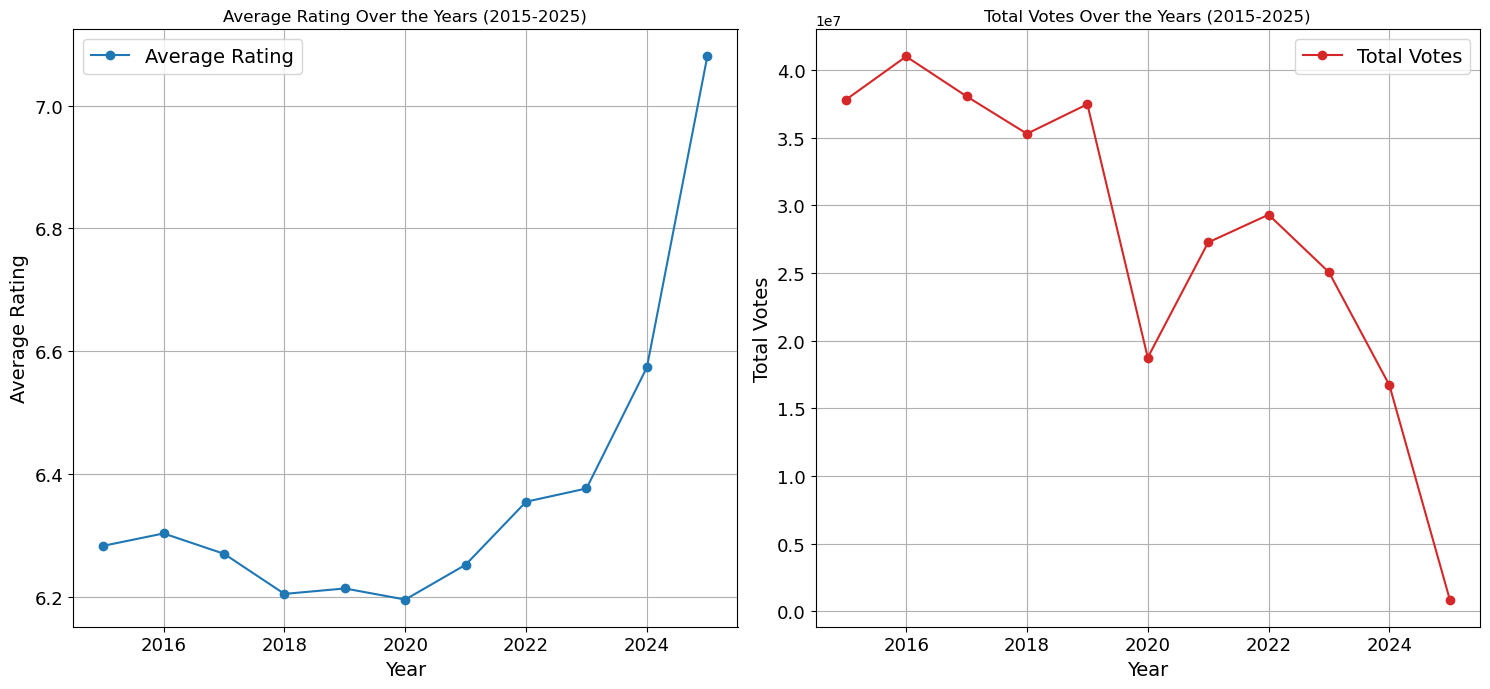

In [198]:
yearly_trends = movies_new.groupby("startYear").agg(
    average_rating=("averageRating", "mean"),
    total_votes=("numVotes", "sum"),
    movie_count=("tconst", "count")
).reset_index()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot 1: Average Rating Over the Years
axes[0].plot(yearly_trends["startYear"], yearly_trends["average_rating"], marker="o", color="tab:blue", label="Average Rating")
axes[0].set_title("Average Rating Over the Years (2015-2025)")
axes[0].set_xlabel("Year", fontsize=14)
axes[0].tick_params(axis='x', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)
axes[0].set_ylabel("Average Rating",fontsize=14)
axes[0].legend(fontsize=14)
axes[0].grid(True)

# Plot 2: Total Votes Over the Years
axes[1].plot(yearly_trends["startYear"], yearly_trends["total_votes"], marker="o", color="tab:red", label="Total Votes")
axes[1].set_title("Total Votes Over the Years (2015-2025)")
axes[1].set_xlabel("Year", fontsize=14)
axes[1].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)
axes[1].set_ylabel("Total Votes",fontsize=14)
axes[1].legend(fontsize=14)
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

In [199]:
percentiles = movies_new["numVotes"].quantile([0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99])
print(f"{percentiles}")

0.25       18.00
0.50       62.00
0.75      333.00
0.80      525.00
0.85      875.95
0.90     1680.00
0.95     4643.30
0.99    51091.16
Name: numVotes, dtype: float64


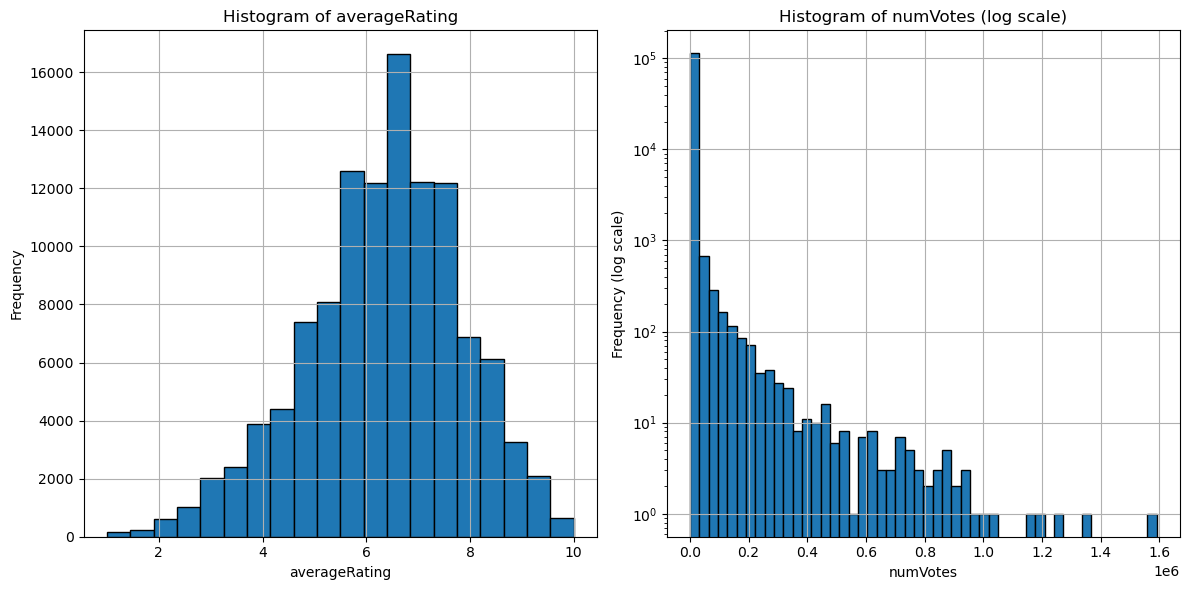

In [200]:
# Histogram for averageRating
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a 1x2 grid, and this is the first subplot
plt.hist(movies_new['averageRating'], bins=20, edgecolor='black')
plt.title('Histogram of averageRating')
plt.xlabel('averageRating')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for numVotes
plt.subplot(1, 2, 2)  # Create a 1x2 grid, and this is the second subplot
plt.hist(movies_new['numVotes'], bins=50, edgecolor='black', log=True) #log scale for better visualization
plt.title('Histogram of numVotes (log scale)')
plt.xlabel('numVotes')
plt.ylabel('Frequency (log scale)')
plt.grid(True)

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

In [210]:
#Compute the Mean Rating Across All Movies
C = movies_new["averageRating"].mean()

#Filter Movies with Votes
m = movies_new["numVotes"].quantile(0.75)
qualified_movies_new = movies_new[movies_new["numVotes"] >= m].copy()

# Step 4: Apply Weighted Rating (WR) Formula
def weighted_rating(df, m=m, C=C):
    v = df["numVotes"]
    R = df["averageRating"]
    return (v / (v + m) * R) + (m / (v + m) * C)

#Apply Weighted Rating (WR) Formula
qualified_movies_new.loc[:, "WR"] = qualified_movies_new.apply(weighted_rating, axis=1)


In [211]:
qualified_movies_new.sort_values(by="WR", ascending=False).iloc[:10]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,WR
8033867,tt33175825,movie,Attack on Titan the Movie: The Last Attack,Shingeki no Kyojin: The Last Attack,0,2024.0,145,"Action,Adventure,Animation",9.3,12985.0,9.225186
5428517,tt21272942,movie,The Strangers' Case,The Strangers' Case,0,2024.0,103,Drama,9.3,7614.0,9.174623
6831357,tt28455855,movie,Nidurinchu jahapana,Nidurinchu jahapana,0,2025.0,118,Drama,9.6,2047.0,9.139384
8332163,tt34604827,movie,Fire,Fire,0,2025.0,132,Crime,9.2,10226.0,9.108792
7070191,tt29415777,movie,Jithender Reddy,Jithender Reddy,0,2024.0,136,Action,9.5,2324.0,9.099937
8043304,tt33240751,movie,Rewind,Rewind,0,2024.0,135,Drama,9.4,2222.0,8.996999
8086791,tt33337133,movie,Racharikam,Racharikam,0,2025.0,135,Romance,9.4,2044.0,8.966821
4446546,tt16591746,movie,Guard: Revenge for Love,Guard: Revenge for Love,0,2025.0,135,"Horror,Thriller",9.4,2027.0,8.963700
5492331,tt21419928,movie,Let's Meet,Let's Meet,0,2025.0,103,Romance,9.1,5061.0,8.927629
4480784,tt16747572,movie,The Silence of Swastika,The Silence of Swastika,0,2021.0,56,"Documentary,History",9.0,10611.0,8.918086


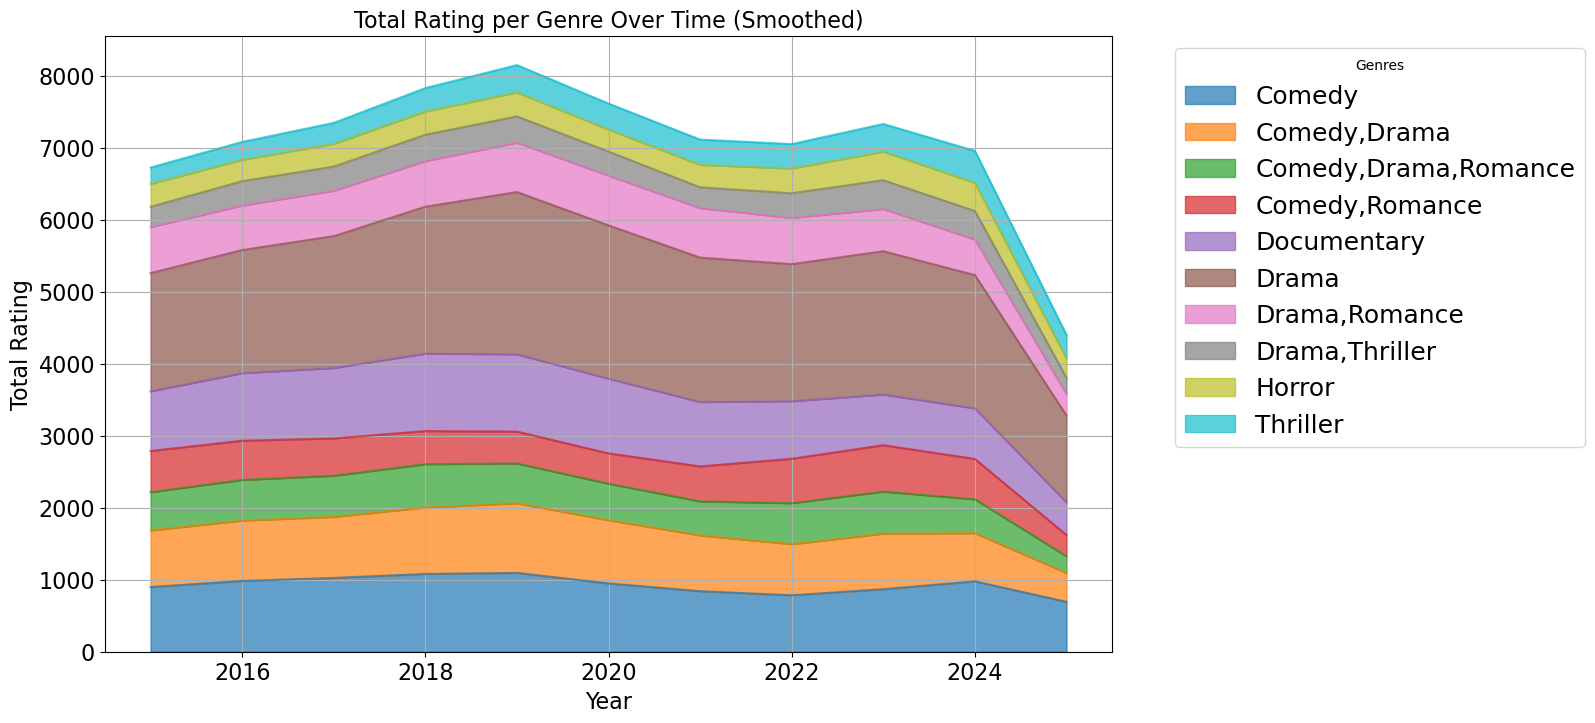

In [ ]:
# Explode genres into separate rows
movies_exploded = qualified_movies_new.explode("genres")

# Keep only the top 10 genres
top_genres = movies_exploded["genres"].value_counts().head(10).index.tolist()

# Filter using exploded dataset
filtered_movies = movies_exploded[movies_exploded["genres"].isin(top_genres)]

# Aggregate rating per year and genre
genre_trends = (
    filtered_movies.groupby(["startYear", "genres"])
    .agg(WR=("WR", "sum"))
    .reset_index()
)

# Pivot for plotting
genre_trends_pivot = genre_trends.pivot(index="startYear", columns="genres", values="WR").fillna(0)

 

# Apply rolling average for smoothing
genre_trends_pivot = genre_trends_pivot.rolling(window=3, min_periods=1).mean()

# Plot
genre_trends_pivot.plot(kind="area", stacked=True, figsize=(13, 8), alpha=0.7)
plt.title("Total Rating per Genre Over Time (Smoothed)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Total Rating", fontsize=16)
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), fontsize=18)
plt.grid(True)
plt.show()


# Debugging: Ensure data is numeric and non-empty (uncomment if needed)
# print(genre_trends_pivot.head())  
# print(genre_trends_pivot.dtypes) 

In [246]:
sorted_genres = genre_trends[["WR", "genres"]].sort_values(by="WR", ascending=False)
print(f"{sorted_genres["genres"].unique()}")

['Drama' 'Documentary' 'Comedy' 'Comedy,Drama' 'Comedy,Romance'
 'Drama,Romance' 'Comedy,Drama,Romance' 'Drama,Thriller' 'Thriller'
 'Horror']
